#TFM Néstor Félix



Este notebook usará la biblioteca UrbanPy del BID (un proyecto open source para automatizar la extracción, medición y visualización de métricas de accesibilidad urbana). La librería se basa en información abierta a partir del proyecto de [OpenStreetMap](https://www.openstreetmap.org/). OpenStreetMap (OSM) es un servicio de mapas online que publica información contribuida en forma libre. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import sys
sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px
import osmnx as ox

## Descarga de datos urbanos



Definimos en primer lugar la ciudad o país que queremos analizar. En este caso Argentina

In [2]:
arg = 'Argentina'
arg = up.download.nominatim_osm(arg)

Text(0.5, 1.0, '                                            geometry  place_id  osm_type  \\\n0  MULTIPOLYGON (((-73.56054 -49.94247, -73.56048...  16700470  relation   \n\n   osm_id  place_rank  category            type  importance addresstype  \\\n0  286393           4  boundary  administrative    0.810104     country   \n\n        name display_name  \n0  Argentina    Argentina  ')

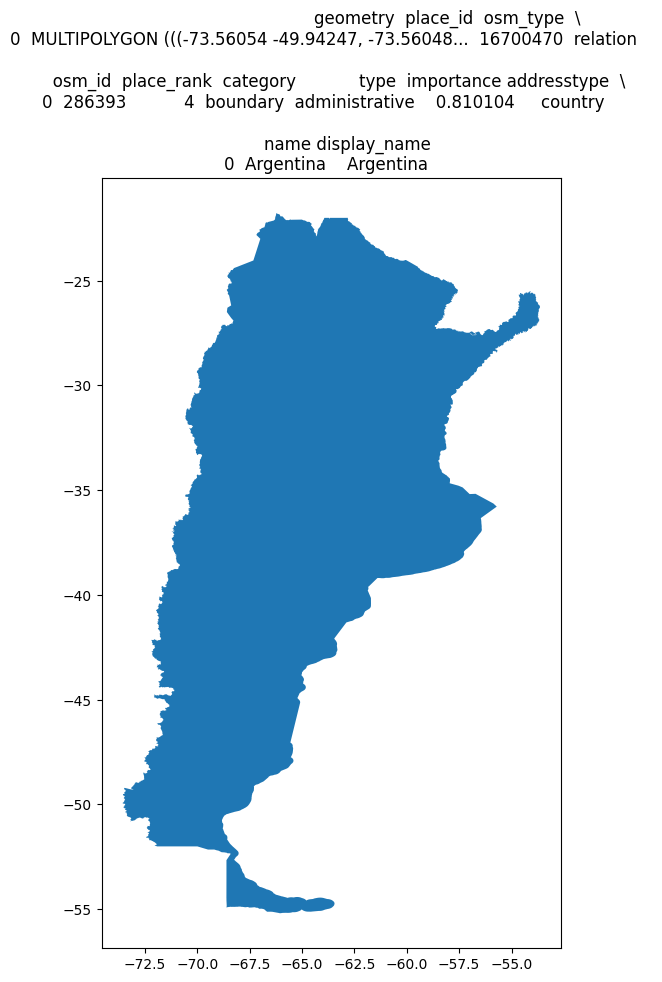

In [3]:
arg.plot()
plt.title(arg)

Para aplicar algoritmos y visualizar datos espaciales variados definimos una unidad espacial uniforme con el paquete [Uber H3](https://eng.uber.com/h3/) para dividir la el mapa en hexágonos uniformes.

In [4]:
h3_resolution = 5

hex_arg = up.geom.gen_hexagons(h3_resolution, city=arg)

In [ ]:
hex_arg.plot()
plt.title(arg + ". Celdas H3 de resolución " + str(h3_resolution))

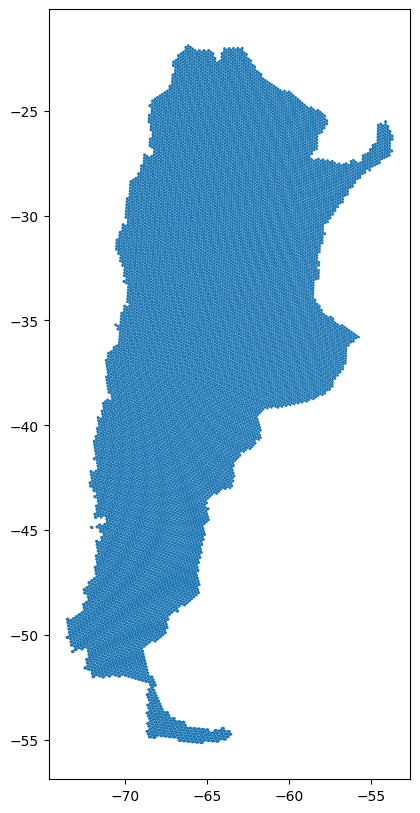

Podemos utilizar la función *head* para ver los primeros registros.


In [6]:
hex_arg.head()

,hex,geometry
0,85a96513fffffff,"POLYGON ((-59.11160 -29.68580, -59.06164 -29.6..."
1,85b22cbbfffffff,"POLYGON ((-67.37591 -24.98490, -67.42914 -25.0..."
2,85c32c33fffffff,"POLYGON ((-66.19492 -42.23579, -66.16776 -42.1..."
3,85cf8397fffffff,"POLYGON ((-69.57310 -47.61810, -69.53571 -47.5..."
4,85b2658bfffffff,"POLYGON ((-61.89822 -26.74460, -61.94714 -26.8..."


La función *shape* nos permite ver el tamaño del dataset.


In [7]:
hex_arg.shape

(14202, 2)

En este caso, Argentina está dividida en 14202 hexágonos

## Descarga de datos de población

La información de datos de población se descarga a nivel país con la función *hdx_fb_population* disponible en la librería UrbanPy.
En esta función se define en primer lugar el país, y luego el tipo de población: *full* (refiere a toda la población), *children* (refiere a niños y niñas), *youth* (refiere a jóvenes) y *elderly* (refiere a la población adulta).
La función accede a los [estimados demográficos de alta resolución que ha creado Facebook](https://dataforgood.facebook.com/dfg/docs/high-resolution-population-density-maps-demographic-estimates-documentation), con datos precisos sobre la densidad de población en cualquier parte del mundo.

In [8]:
pop_arg = up.download.hdx_dataset('6cf49080-1226-4eda-8700-a0093cbdfe4d/resource/5737d87f-e17f-4c82-b1bd-d589ed631318/download/arg_general_2020_csv.zip')

Una vez que tenemos los datos de población, utilizamos la función head para ver los primeros registros.  

In [9]:
pop_arg.head()

,longitude,latitude,arg_general_2020
0,-68.792917,-20.999861,15.589419
1,-65.742361,-20.999861,9.786258
2,-65.615694,-20.999861,9.786258
3,-64.682639,-20.999861,3.107346
4,-63.332361,-20.999861,2.909961


Tenemos los datos de población de cada hexágono para 2020 y todo el país

In [11]:
# en el caso de un provincia o ciudad se podría filtrar con 
pop_arg = up.geom.filter_population(pop_arg, arg)

Al aplicar la función *filter_population*, filtramos la población dentro del bounding box que contiene a nuestra ciudad.
El bounding box (o caja de coordenadas) refiere a las coordenadas de un rectángulo que abarque la zona de interés, es decir los valores máximos y mínimos de latitud y longitud.



<Axes: >

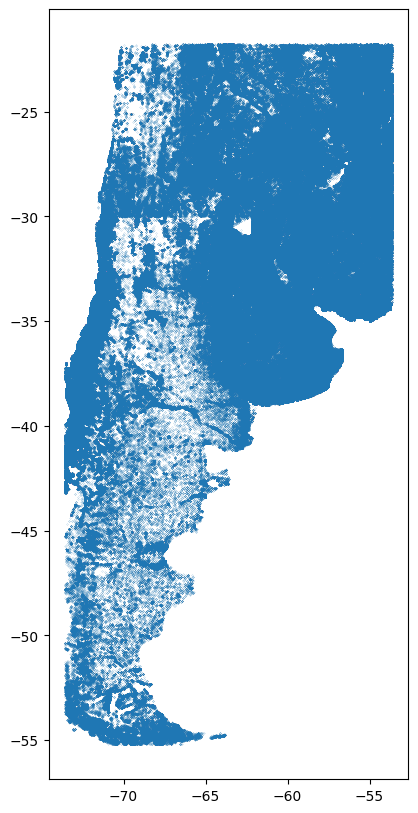

In [12]:
# para revisar el filtrado 
pop_arg.plot(markersize = 0.01)

Ahora que tenemos los puntos de población, y los hexágonos, vamos a calcular la población por hexagono. Para eso, se utiliza la función *merge_shape_hex*


In [13]:
hex_arg = up.geom.merge_shape_hex(hex_arg, pop_arg, agg={'arg_general_2020':'sum'})

In [14]:
hex_arg.head()

,hex,geometry,arg_general_2020
0,85a96513fffffff,"POLYGON ((-59.11160 -29.68580, -59.06164 -29.6...",817.389920
1,85b22cbbfffffff,"POLYGON ((-67.37591 -24.98490, -67.42914 -25.0...",15.069760
2,85c32c33fffffff,"POLYGON ((-66.19492 -42.23579, -66.16776 -42.1...",3.579724
3,85cf8397fffffff,"POLYGON ((-69.57310 -47.61810, -69.53571 -47.5...",13.952341
4,85b2658bfffffff,"POLYGON ((-61.89822 -26.74460, -61.94714 -26.8...",345.888852


Veamos los datos en un mapa


In [ ]:
hex_arg.plot('arg_general_2020', legend=True, missing_kwds={'color':'grey'})
plt.title(arg + ". Población 2020")

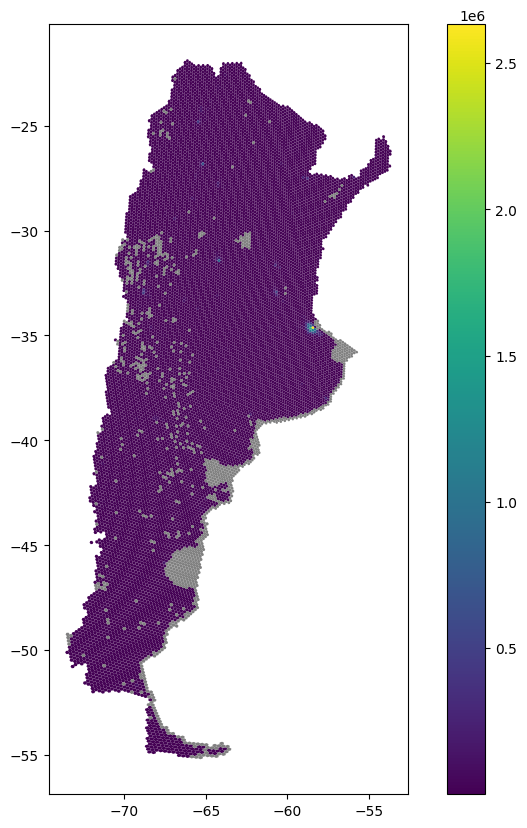

Vamos a armar un mapa interactivo para visualizar la información. Para eso, podemos utilizar la función *choropleth_map*. Esta función se basa en *choropleth_mapbox* de la librería *plotly*. [Aquí](https://plotly.com/python/mapbox-county-choropleth/) se pueden ver más parámetros para configurar.


In [17]:
fig = up.plotting.choropleth_map(hex_arg, 'arg_general_2020', title=arg + '. Población estimada - 2020',
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'arg_general_2020':'Población 2020'}
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U27')) -> None

Observamos que los patrones en los gráficos son muy similares.

<font color="grey"> [English] We note that the patterns in the graphs are very similar.   

<font color="grey"> [Portugues] Observamos que os padrões nos gráficos são muito semelhantes.

## Accesibilidad urbana


Para evaluar accesibilidad urbana, es necesario primero definir accesibilidad a que lugar(es) de interés, para luego obtener los datos de esos puntos de interés.  
Para obtener datos georeferenciados de puntos de interés realizaremos consultas a [Overpass](https://overpass-api.de/), una interfaz que permite extraer información de la base de datos global de OpenStreetMap. En [este wiki](https://wiki.openstreetmap.org/wiki/Map_features) se pueden consultar los datos disponibles en OSM.

Overpass requiere que se especifique un *bounding box*. Para obtenerlo, se puede usar la propiedad *total_bounds*, que devuelve un array con los valores.



In [18]:
arg.total_bounds

array([-73.5605371, -55.1925709, -53.6374515, -21.7808568])

En este ejemplo, nos interesa evaluar la accesibilidad a establecimientos escolares. 


In [19]:
es = up.download.overpass_pois(bounds=arg.total_bounds, facilities='education')  # {'food', 'health', 'education', 'finance'}

Nuevamente, utilizamos la función *head* para ver los primeros resultados.


In [20]:
es.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,3,-34.814075,-58.489974,"{'amenity': 'kindergarten', 'name': 'El Duende...",POINT (-58.48997 -34.81408),kindergarten
1,node,198404677,-32.917468,-62.455541,"{'addr:city': 'Monte Buey', 'addr:country': 'A...",POINT (-62.45554 -32.91747),school
2,node,198438917,-28.847672,-66.929471,"{'addr:city': 'Aminga', 'addr:postcode': '5301...",POINT (-66.92947 -28.84767),school
3,node,198450551,-28.778297,-61.664118,"{'amenity': 'school', 'is_in': 'Argentina, Sou...",POINT (-61.66412 -28.77830),school
4,node,198450698,-31.586114,-60.939191,"{'addr:city': 'Franck', 'addr:postcode': 'S300...",POINT (-60.93919 -31.58611),school


Podemos ver diferentes tipos de establecimientos relacionados con establecimiento de salud. Veamos cuales son.


In [21]:
es.poi_type.value_counts()

poi_type
school                            29430
kindergarten                       6246
college                             928
university                          567
language_school                     127
driving_school                      119
music_school                         59
ski_school                           18
prep_school                          10
dancing_school                        6
surf_school                           2
dance_school                          2
windsurf_school                       1
kindergarten;library                  1
pharmacy;college                      1
kindergarten;school;university        1
school;kindergarten                   1
school;restaurant                     1
Name: count, dtype: int64

Veamos los geometrías en un mapa.


Text(0.5, 1.0, '. Puntos de interés OSM, categoría escuelas')

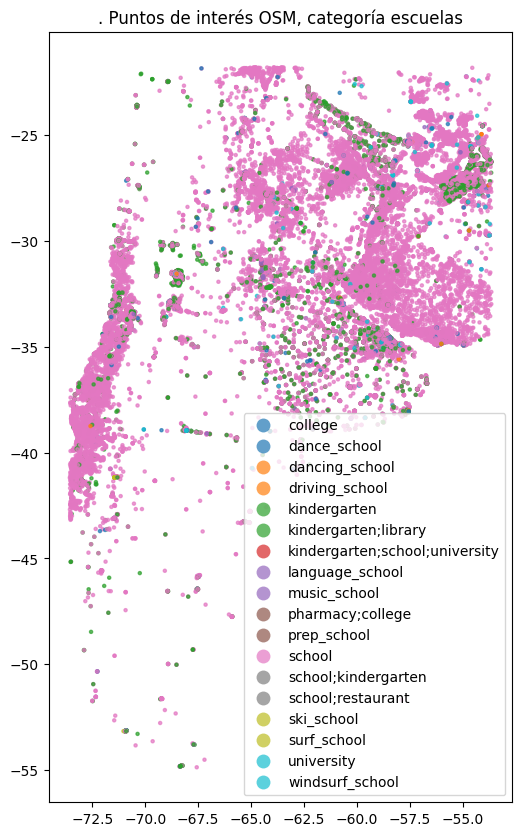

In [24]:
es.plot('poi_type', markersize = 5, alpha = 0.7, legend=True)
plt.title(". Puntos de interés OSM, categoría escuelas")

### Acceso a escuelas


Primero evaluamos la accesibilidad a escuelas. Para eso vamos a filtrar los datos descargados por el tipo 'school'.



In [25]:
escuelas = es[es['poi_type'] == 'school' ]

Visualicemos solo las escuelas.

<Axes: >

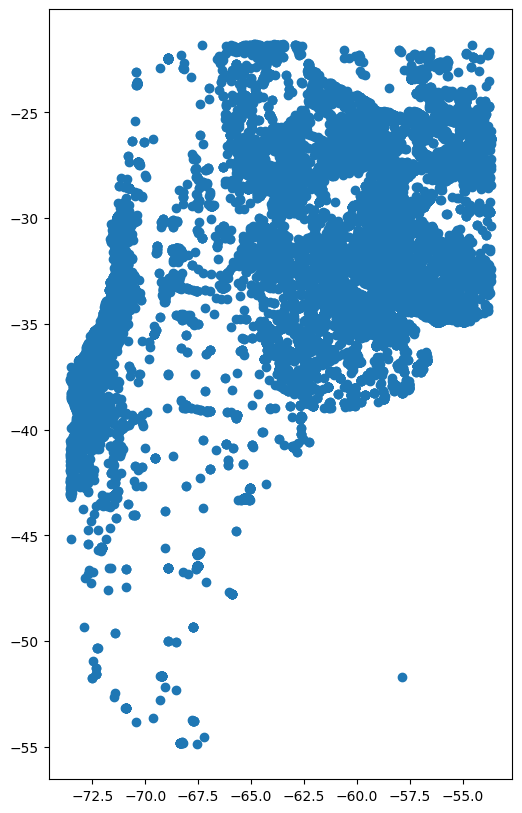

In [26]:
escuelas.plot()

Ahora que tenemos la ubicación de las escuelas, calcularemos la distancia a la escuela más cercana desde el centroide de los hexagonos.
Primero, vamos a calcular los centroides.

In [27]:
hex_arg['lat'] = hex_arg.geometry.centroid.y
hex_arg['lon'] = hex_arg.geometry.centroid.x

Dentro de la librería *UrbanPy*, podemos utilizar la función *nn_search* para localizar los vecinos más cercanos (nearest neighboor).  


In [28]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=escuelas[['lat', 'lon']].values, # Puntos de interes
    query_features=hex_arg[['lat', 'lon']].values, # Centroides de los hexagonos
    metric='haversine' # Metrica de distancia
)

Agregamos la variable 'escuela_cercana' que indica el índice de la escuela más cercana para ese hexágono.


In [29]:
hex_arg['escuela_cercana'] = ind_up
hex_arg.head()

,hex,geometry,arg_general_2020,lat,lon,escuela_cercana
0,85a96513fffffff,"POLYGON ((-59.11160 -29.68580, -59.06164 -29.6...",817.389920,-29.612958,-59.154498,20167
1,85b22cbbfffffff,"POLYGON ((-67.37591 -24.98490, -67.42914 -25.0...",15.069760,-25.060497,-67.333444,2144
2,85c32c33fffffff,"POLYGON ((-66.19492 -42.23579, -66.16776 -42.1...",3.579724,-42.171053,-66.265181,16787
3,85cf8397fffffff,"POLYGON ((-69.57310 -47.61810, -69.53571 -47.5...",13.952341,-47.550323,-69.649961,10574
4,85b2658bfffffff,"POLYGON ((-61.89822 -26.74460, -61.94714 -26.8...",345.888852,-26.814742,-61.856610,16282


Iniciar el servidor de ruteo de OSM.   




```
up.routing.start_osrm_server('argentina', 'south-america', 'foot')



Aplicamos la función de ruteo a nuestro dataset.


```
distance_duration = hex_ba.apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid,
        destination = hospitales.iloc[row['hosp_cercano']]['geometry']
    ),
    result_type='expand',
    axis=1,
)
```

Corrimos previamente la función de manera local, y guardamos los resultados en un archivo de tipo csv.


```
distance_duration.to_csv("distance_duration.csv", index = False)
```

In [30]:
#distance_duration = pd.read_csv("csv")

In [31]:
#distance_duration.head()

El dataset resultante contiene 2 variables:  
0 corresponde a la distancia  
1 corresponde a la duración del recorrido  

Vamos a incorporar estas dos variables a nuestro dataset *hex_arg*.



In [ ]:
hex_arg['distancia_a_escuelas'] =  distance_duration["0"] / 1000 # metros a km
hex_arg['duracion_a_escuelas'] = distance_duration["1"] / 60 # segundos a minutos

Veamos los resultados:


In [ ]:
hex_arg.head()

Vamos a realizar un mapa que muestre la duración de viajes hasta la escuela más cercana.

continuará
